In [ ]:
!pip install -q  langchain datasets ftfy accelerate scipy safetensors
# Installing transformers from source for now since we need the latest version for Depth2Img:
!pip install -q git+https://github.com/huggingface/diffusers
!pip install -Uq git+https://github.com/huggingface/transformers
!pip install -q omegaconf torchvision safetensors
!pip install -q torch==2.0.1

!pip install -q xformers


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 2.0.1 which is incompatible.


In [ ]:
! wget -O test_models.safetensors $(curl https://civitai.com/api/download/models/44787 )

In [ ]:
!git clone https://github.com/huggingface/diffusers
!git clone https://github.com/Mikubill/sd-webui-controlnet.git

fatal: destination path 'diffusers' already exists and is not an empty directory.
fatal: destination path 'sd-webui-controlnet' already exists and is not an empty directory.


In [ ]:
!python ./diffusers/scripts/convert_original_controlnet_to_diffusers.py \
    --checkpoint_path ./test_models.safetensors \
    --original_config_file ./sd-webui-controlnet/models/control_sd15_openpose.yaml \
    --from_safetensors \
    --dump_path ./test_model --to_safetensors --device cuda

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
!ls -lh ./test_model

total 1.4G
-rw-r--r-- 1 root root 1.2K Jul 24 13:21 config.json
-rw-r--r-- 1 root root 1.4G Jul 24 13:21 diffusion_pytorch_model.safetensors


In [ ]:
# #lora
!python ./diffusers/scripts/convert_lora_safetensor_to_diffusers.py \
--base_model_path runwayml/stable-diffusion-v1-5 \
--checkpoint_path ./test_model/AlisonBrie.safetensors \
--dump_path ./test_model \
 --to_safetensors --device cuda

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
!cp /kaggle/input/lora1111/AlisonBrie.safetensors /kaggle/working/test_model

In [ ]:
# !cp /kaggle/input/lore-2/Delorean-80s-aerobics-v3.safetensors /kaggle/working/test_model

In [ ]:
# # #lora
# !python ./diffusers/scripts/convert_lora_safetensor_to_diffusers.py \
# --base_model_path runwayml/stable-diffusion-v1-5 \
# --checkpoint_path ./test_mode/Delorean-80s-aerobics-v3.safetensors \
# --dump_path ./test_mode \
#  --to_safetensors --device cuda

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
import os
import gc
import copy
import time
import random
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

from huggingface_hub import notebook_login

notebook_login()


from diffusers import StableDiffusionPipeline,ControlNetModel
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
)


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

print(torch.cuda.device_count())

1


In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

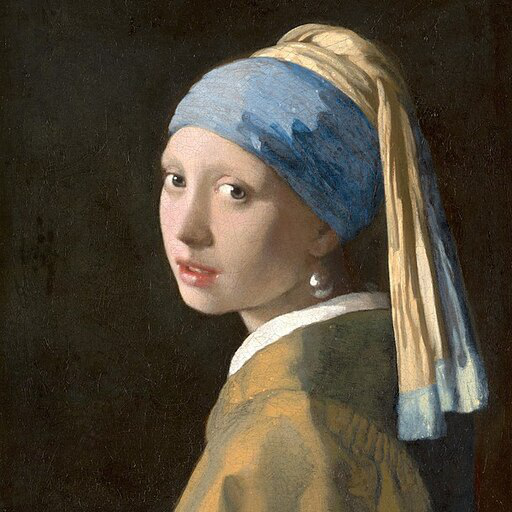

In [ ]:
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

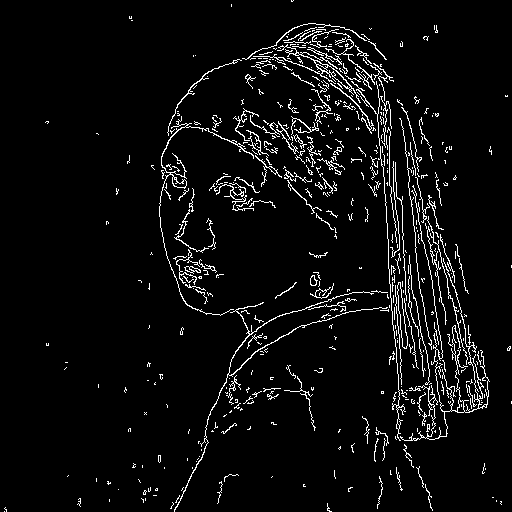

In [ ]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
import os
import gc
import copy
import time
import random
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline
import torch
from diffusers import UniPCMultistepScheduler, EulerAncestralDiscreteScheduler
import transformers
import os
from PIL import Image
import numpy as np
import cv2

from huggingface_hub import notebook_login

notebook_login()

# Utils
from tqdm import tqdm
from collections import defaultdict


from diffusers import StableDiffusionPipeline,ControlNetModel
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
)

print(torch.cuda.device_count())

1


Now, we load runwaylml/stable-diffusion-v1-5 as well as the ControlNet model for canny edges. The models are loaded in half-precision (torch.dtype) to allow for fast and memory-efficient inference.

In [ ]:
controlnet = ControlNetModel.from_pretrained("./test_model", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
       "runwayml/stable-diffusion-v1-5",
       controlnet=controlnet,
       safety_checker=None,
       torch_dtype=torch.float16
       ).to('cuda:0')

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.vae.enable_tiling()
pipe.safety_checker = None


generator = torch.Generator(device="cuda").manual_seed(2)
prompt = ["A victorian woman with blue eyes and red hair wearing intricate silver metal crystal, best quality, extremely detailed"]
result_img = pipe(
      prompt,
      image=canny_image,
      negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"],
      num_inference_steps=20,
      generator=generator,
      guidance_scale=3).images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
result_img

# Weighting prompts
Open In Colab
Open In Studio Lab
Text-guided diffusion models generate images based on a given text prompt. The text prompt can include multiple concepts that the model should generate and it’s often desirable to weight certain parts of the prompt more or less.

Diffusion models work by conditioning the cross attention layers of the diffusion model with contextualized text embeddings (see the Stable Diffusion Guide for more information). Thus a simple way to emphasize (or de-emphasize) certain parts of the prompt is by increasing or reducing the scale of the text embedding vector that corresponds to the relevant part of the prompt. This is called “prompt-weighting” and has been a highly demanded feature by the community (see issue here).

# https://huggingface.co/docs/diffusers/main/en/using-diffusers/weighted_prompts

In [ ]:
!pip install -q compel

In [ ]:
from compel import Compel

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

prompt_embeds = compel_proc(prompt)

  0%|          | 0/20 [00:00<?, ?it/s]

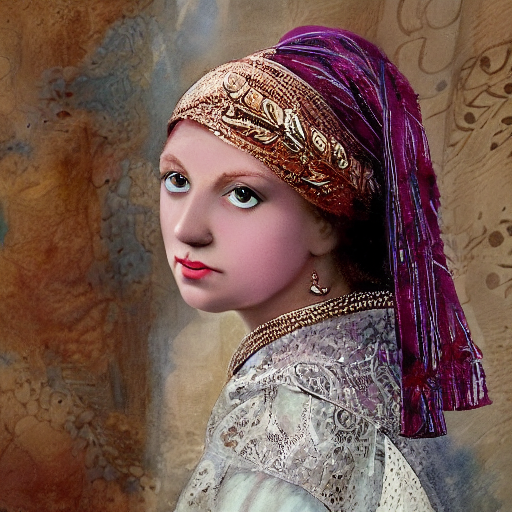

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(2)

img = pipe(
      prompt_embeds=prompt_embeds,
      image=canny_image,
      negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality,blur"],
      num_inference_steps=20,
      generator=generator,
      guidance_scale=3).images[0]

img

Now we are ready to run the ControlNet pipeline!

We still provide a prompt to guide the image generation process, just like what we would normally do with a Stable Diffusion image-to-image pipeline. However, ControlNet will allow a lot more control over the generated image because we will be able to control the exact composition in generated image with the canny edge image we just created.

It will be fun to see some images where contemporary celebrities posing for this exact same painting from the 17th century. And it's really easy to do that with ControlNet, all we have to do is to include the names of these celebrities in the prompt!

Let's first create a simple helper function to display images as a grid.

  0%|          | 0/20 [00:00<?, ?it/s]

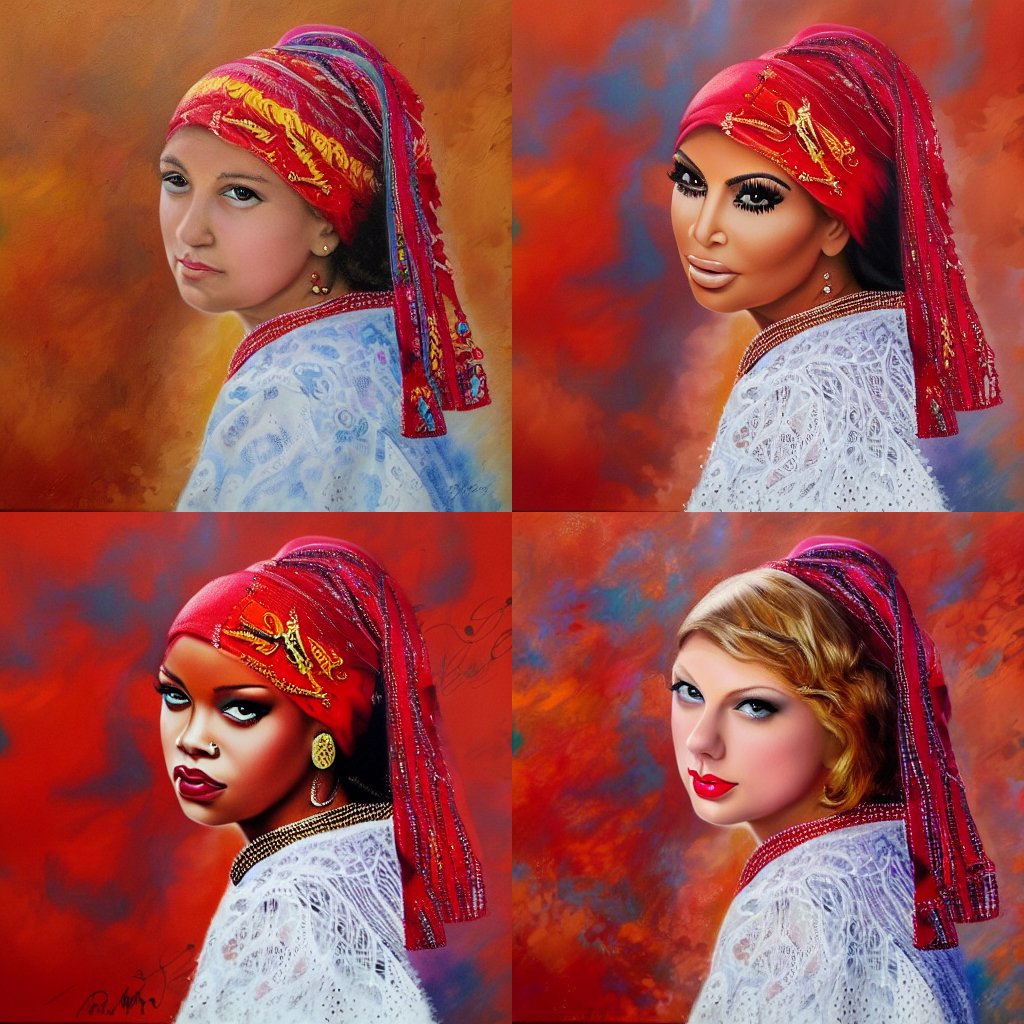

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = "best quality, extremely detailed,portrait"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cuda").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)

  0%|          | 0/20 [00:00<?, ?it/s]

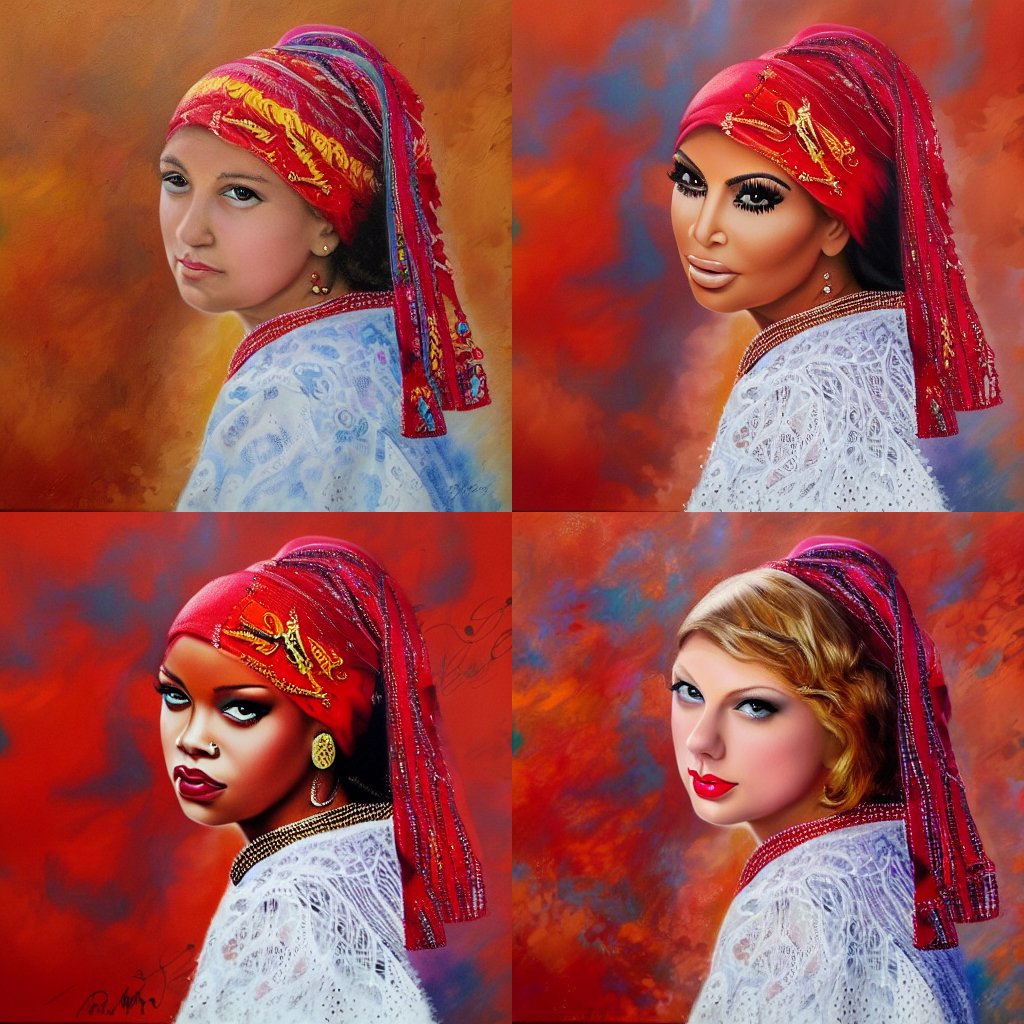

In [ ]:
from compel import Compel

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

prompt_embeds = compel_proc(prompt)

generator = torch.Generator(device="cuda").manual_seed(2)

img = pipe(
      prompt_embeds=prompt_embeds,
      image=canny_image,
      negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
      num_inference_steps=20,
      generator=generator,
      guidance_scale=3).images[0]

image_grid(output.images, 2, 2)

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

api.upload_folder(
    folder_path = "./test_model" ,
    repo_id = "Andyrasika/control_diffusion" ,
    repo_type = "model"
)

Delorean-80s-aerobics-v3.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

'https://huggingface.co/Andyrasika/control_diffusion/tree/main/'

Multi-control net production process construction

In [ ]:
from safetensors.torch import load_file
#https://qiita.com/Limitex/items/275d91dd4acdbf57b5f4

def load_safetensors_lora(pipeline, checkpoint_path, LORA_PREFIX_UNET="lora_unet", LORA_PREFIX_TEXT_ENCODER="lora_te", alpha=0.75):
    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path)

    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        # as we have set the alpha beforehand, so just skip
        if ".alpha" in key or key in visited:
            continue

        if "text" in key:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        pair_keys = []
        if "lora_down" in key:
            pair_keys.append(key.replace("lora_down", "lora_up"))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace("lora_up", "lora_down"))

        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

        # update visited list
        for item in pair_keys:
            visited.append(item)

    return pipeline

In [ ]:
import datetime
import time
import torch
from diffusers import StableDiffusionPipeline
from diffusers.models import AutoencoderKL


print('model load')
load_time = time.time()
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
    vae=AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path='stabilityai/sdxl-vae',
        torch_dtype=torch.float16
    ),
    controlnet=controlnet,
    safety_checker=None,
    requires_safety_checker=False,

)

pipe = load_safetensors_lora(
    pipe,
    './test_model/AlisonBrie.safetensors'
).to("cuda")

pipe.safety_checker = None if pipe.safety_checker is None else lambda images, **kwargs: (images, False)
pipe.enable_attention_slicing()

time_load = time.time() - load_time
print(f"Models loaded in {time_load:.2f}s")

generator = torch.Generator(device="cuda").manual_seed(2)
prompt = ["A victorian woman with blue eyes and red hair wearing intricate silver metal crystal, best quality, extremely detailed"]

image = pipe(
    image=canny_image,
    prompt= prompt,
    height=768,
    width=512,
    num_inference_steps=28,
    guidance_scale=12.0,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"]
).images[0]

model load


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Models loaded in 9.17s


  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
image

In [ ]:
# #https://github.com/huggingface/diffusers/issues/3233
# controlnet = ControlNetModel.from_pretrained("./test_model", torch_dtype=torch.float16)
# pipe = StableDiffusionControlNetPipeline.from_pretrained(
#        "runwayml/stable-diffusion-v1-5",
#        controlnet=controlnet,
#        safety_checker=None,
#     requires_safety_checker=False,
#        torch_dtype=torch.float16
#        )
# # lora = ("./test_mode/AlisonBrie.safetensors",1.1)
# # pipe.lora = __load_lora(pipeline=pipe,lora_path=lora[0],lora_weight=lora[1])
# pipe=load_lora_weights(pipe, './test_model.safetensors',1.0,'cuda',torch.float16)
# pipe.to("cuda")
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_xformers_memory_efficient_attention()
# pipe.vae.enable_tiling()
# pipe.safety_checker = None


# generator = torch.Generator(device="cuda").manual_seed(2)
# prompt = ["A victorian woman with blue eyes and red hair wearing intricate silver metal crystal, best quality, extremely detailed"]
# result_img = pipe(
#       prompt,
#       image=input_image,
#       negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"],
#       num_inference_steps=20,

#       guidance_scale=3).images[0]
# result_img

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ https://github.com/huggingface/diffusers/issues/3233                                             │
│       ▲                                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [ ]:
# !git clone https://github.com/sail-sg/EditAnything.git

Cloning into 'EditAnything'...
remote: Enumerating objects: 1155, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 1155 (delta 338), reused 378 (delta 250), pack-reused 657
Receiving objects: 100% (1155/1155), 33.05 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (584/584), done.


In [ ]:
# !python ./diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
#     --checkpoint_path ./test_model.safetensors \
#     --original_config_file ./EditAnything/models/cldm_v21.yaml \
#     --from_safetensors \
#     --dump_path ./test_model --to_safetensors --device cuda

#IMAGE TO IMAGE  

In [ ]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
    )

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [ ]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# FINE TUNING WITH DREAMBOOTH

We can effortlessly combine ControlNet with fine-tuning too! For example, we can fine-tune a model with DreamBooth, and use it to render ourselves into different scenes.

In this post, we are going to use our beloved Mr Potato Head as an example to show how to use ControlNet with DreamBooth.

We can use the same ControlNet. However, instead of using the Stable Diffusion 1.5, we are going to load the Mr Potato Head model into our pipeline - Mr Potato Head is a Stable Diffusion model fine-tuned with Mr Potato Head concept using Dreambooth 🥔

Let's run the above commands again, keeping the same controlnet though